# **IBM ARTICLE RECOMMENDATION PROJECT**

## **1.** **Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from numpy.linalg import svd

## **2.** **Load the Dataset**

In [2]:
# Load the dataset (ensure the CSV file is in your working directory)
df = pd.read_csv("user-item-interactions.csv")

# Rename 'email' column to 'user_id' for consistency with standard recommendation system notation
df.rename(columns={'email': 'user_id'}, inplace=True)

## **3.** **Exploratory Data Analysis**

In [3]:
# Calculate number of unique users
unique_users = df['user_id'].nunique()

# Calculate number of unique articles
unique_articles = df['article_id'].nunique()

# Total number of user-article interactions
user_article_interactions = df.shape[0]

# Find the most viewed article ID and its number of views
most_viewed_article_id = df['article_id'].value_counts().idxmax()
max_views = df['article_id'].value_counts().max()

# Median number of articles interacted with per user
median_val = df.groupby('user_id')['article_id'].count().median()

# Max number of interactions by any single user
max_views_by_user = df.groupby('user_id')['article_id'].count().max()

In [4]:
# Print the EDA summary statistics
print(f"Unique Users: {unique_users}\nUnique Articles: {unique_articles}")
print(f"Total Interactions: {user_article_interactions}")
print(f"Most Viewed Article ID: {most_viewed_article_id} with {max_views} views")
print(f"Median interactions per user: {median_val}, Max interactions by a user: {max_views_by_user}")

# Create a user-item interaction matrix (binary: 1 if user interacted with article, 0 otherwise)
user_item = df.groupby(['user_id', 'article_id']).size().unstack().fillna(0)
user_item[user_item > 0] = 1  # Convert to binary interaction

Unique Users: 5148
Unique Articles: 714
Total Interactions: 45993
Most Viewed Article ID: 1429.0 with 937 views
Median interactions per user: 3.0, Max interactions by a user: 364


In [5]:
def get_article_titles(article_ids, df=df):
    """Return a list of article titles for the given list of article_ids"""
    article_ids = [float(i) for i in article_ids]  # Ensure type consistency with dataset
    title_map = df[['article_id', 'title']].drop_duplicates().set_index('article_id')['title'].to_dict()
    return [title_map.get(i, f"Title not found for Article ID {i}") for i in article_ids]



## **4.** **Rank Based Recommendations**

In [7]:
def get_top_articles(n, df=df):
  """
    Return the top `n` article IDs based on number of user interactions.

    Args:
    n (int): Number of top articles to return
    df (DataFrame): Dataset containing article interactions

    Returns:
    list: List of top article IDs
    """
  return df['article_id'].value_counts().head(n).index.tolist()

def get_top_article_titles(n, df=df):
    """
    Return the top `n` article titles based on number of user interactions.

    Args:
    n (int): Number of top articles to return
    df (DataFrame): Dataset containing article interactions

    Returns:
    list: List of article titles corresponding to the top article IDs
    """
    top_articles = get_top_articles(n)
    return df[df['article_id'].isin(top_articles)]['title'].drop_duplicates().tolist()

print("Top 5 Articles from Rank-Based Recommendation:")
ranked_ids = get_top_articles(5)
for title in get_article_titles(ranked_ids):
    print(title)


Top 5 Articles from Rank-Based Recommendation:
use deep learning for image classification
insights from new york car accident reports
visualize car data with brunel
use xgboost, scikit-learn & ibm watson machine learning apis
predicting churn with the spss random tree algorithm


### Rank-Based Recommendations

This approach recommends the most popular articles based on the total number of user interactions (views). It does not rely on user preferences or behavior, making it especially useful for:

- New users with no interaction history
- Default recommendations on landing pages

The functions used:
- `get_top_articles(n)`: Returns the top `n` article IDs.
- `get_top_article_titles(n)`: Returns the top `n` article titles.

Below are the top 5 most popular articles recommended to all users:


## **5.** **User-User Collaborative Filtering**

In [8]:
def find_similar_users(user_id, user_item=user_item):
    """
    Compute and return a list of users most similar to the given user based on cosine similarity.

    Args:
    user_id (str): ID of the user to compare against others
    user_item (DataFrame): User-item interaction matrix (binary)

    Returns:
    Series: A sorted pandas Series of user IDs and similarity scores, excluding the input user
    """
    if user_id not in user_item.index:
        return pd.Series(dtype=float)
    similarity = cosine_similarity(user_item.loc[[user_id]], user_item)[0]
    sim_scores = pd.Series(similarity, index=user_item.index).drop(user_id)
    return sim_scores.sort_values(ascending=False)

def user_user_recs(user_id, m=10, user_item=user_item):
    """
    Generate top `m` article recommendations for a given user using user-user collaborative filtering.

    Args:
    user_id (str): ID of the user to generate recommendations for
    m (int): Number of recommendations to return
    user_item (DataFrame): User-item interaction matrix

    Returns:
    list: List of recommended article IDs that the user has not yet interacted with
    """
    if user_id not in user_item.index:
        return []
    sim_users = find_similar_users(user_id, user_item)
    recs = []
    user_articles = user_item.loc[user_id]

    for sim_user in sim_users.index:
        sim_articles = user_item.loc[sim_user]
        new_recs = sim_articles[sim_articles > 0].index.difference(user_articles[user_articles > 0].index)
        recs.extend(new_recs)
        if len(recs) >= m:
            break

    return list(pd.Series(recs).drop_duplicates().head(m))


In [9]:
# Fallback Recommendations for New Users

def new_user_recs(n=5):
    """
    Provide top-ranked articles for new users with no interaction history.

    Args:
    n (int): Number of articles to recommend

    Returns:
    list: List of top article IDs based on overall popularity
    """
    return get_top_articles(n)

# Example usage
print("New User Recommendations:")
print(get_article_titles(new_user_recs()))


New User Recommendations:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']


### New User Recommendations

To address the cold start problem where a user has no prior interactions, we recommend globally top-ranked articles using `new_user_recs()`.
This ensures a sensible fallback in the absence of user-specific data.


## **6.** **Content-Based Recommendations**

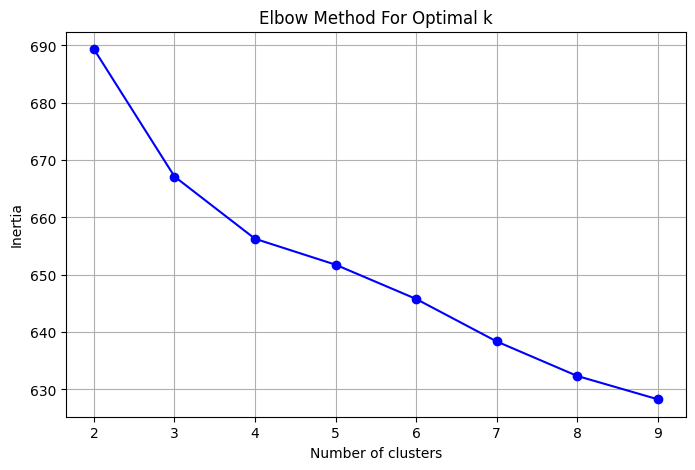

In [10]:
# Prepare article content (here using title as proxy for article content)
article_content = df[['article_id', 'title']].drop_duplicates().copy()
article_content.rename(columns={'title': 'content'}, inplace=True)
article_content = article_content.dropna(subset=['content'])

# Apply TF-IDF vectorization to article content
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(article_content['content'])

# TF-IDF transformation
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(article_content['content'])

# Elbow Method to find optimal number of clusters
import matplotlib.pyplot as plt

distortions = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


# Apply KMeans clustering to group similar articles
kmeans = KMeans(n_clusters=5, random_state=42)
article_content['cluster'] = kmeans.fit_predict(tfidf_matrix)


### Optimal Cluster Selection (Elbow Method)

To determine the optimal number of clusters for article content grouping, we used the Elbow Method.
The plot above shows that after `k=5`, the reduction in inertia slows down, indicating that 5 is a reasonable number of clusters to use.


In [11]:
def content_recs(article_id, n=5, articles=article_content):
    """
    Recommend `n` articles that are similar in content to a given article using KMeans clustering on TF-IDF vectors.

    Args:
    article_id (float or int): ID of the article to find similar content for
    n (int): Number of recommendations to return
    articles (DataFrame): DataFrame containing article_id, content, and cluster assignments

    Returns:
    list: List of article IDs in the same cluster as the input article (excluding the input itself)
    """
    if article_id not in articles['article_id'].values:
        return []
    cluster = articles[articles['article_id'] == article_id]['cluster'].values[0]
    similar_articles = articles[(articles['cluster'] == cluster) & (articles['article_id'] != article_id)]
    return similar_articles['article_id'].head(n).tolist()

## **7.** **Matrix Factorization (SVD)**

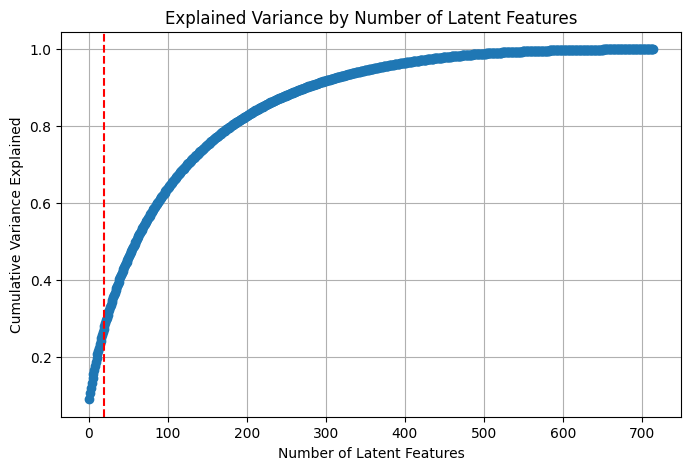

In [12]:
# Perform Singular Value Decomposition
U, s, Vt = svd(user_item, full_matrices=False)

# Plot cumulative explained variance to choose optimal number of features
explained_variance = np.cumsum(s**2 / np.sum(s**2))

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axvline(x=20, color='red', linestyle='--')
plt.xlabel('Number of Latent Features')
plt.ylabel('Cumulative Variance Explained')
plt.title('Explained Variance by Number of Latent Features')
plt.grid(True)
plt.show()

# Select number of latent features
k = 20
U_k, S_k, Vt_k = U[:, :k], np.diag(s[:k]), Vt[:k, :]

# Predict user-article interaction scores using reduced matrices
user_predicted = np.dot(np.dot(U_k, S_k), Vt_k)
user_pred_df = pd.DataFrame(user_predicted, index=user_item.index, columns=user_item.columns)


### Latent Feature Selection for SVD

To choose the optimal number of latent features for matrix factorization, we plotted the cumulative variance explained.
We selected `k=20` as it captures a significant amount of the variance while keeping computation efficient.


In [13]:
def svd_recs(user_id, m=10):
    """
    Generate top `m` article recommendations for a user using matrix factorization (SVD).

    Args:
    user_id (str): The ID of the user to recommend articles for
    m (int): Number of recommendations to return

    Returns:
    list: List of article IDs recommended for the user
    """
    if user_id not in user_item.index:
        return []
    known = user_item.loc[user_id][user_item.loc[user_id] > 0].index
    preds = user_pred_df.loc[user_id].sort_values(ascending=False)
    return preds[~preds.index.isin(known)].head(m).index.tolist()

In [14]:
# Transpose Vt_k to get article embeddings (each row = article vector in latent space)
article_embeddings = pd.DataFrame(Vt_k.T, index=user_item.columns)

def svd_article_recs(article_id, n=5):
    """
    Recommend similar articles based on SVD latent features using cosine similarity.

    Args:
    article_id (int/str): ID of the article to find similar ones for
    n (int): Number of recommendations

    Returns:
    list: List of recommended article IDs
    """
    if article_id not in article_embeddings.index:
        return []
    article_vec = article_embeddings.loc[[article_id]]
    similarity = cosine_similarity(article_vec, article_embeddings)[0]
    sim_scores = pd.Series(similarity, index=article_embeddings.index).drop(article_id)
    return sim_scores.sort_values(ascending=False).head(n).index.tolist()


In [15]:
# Example usage for user-based SVD recs
example_user_id = user_item.index[0]
print(f"SVD-Based Recommendations for User ID: {example_user_id}")
print(svd_recs(example_user_id))

# Example usage for article-to-article SVD recs
print(f"SVD-Based Article Recommendations for Article ID: {most_viewed_article_id}")
print(svd_article_recs(most_viewed_article_id))


SVD-Based Recommendations for User ID: 0000b6387a0366322d7fbfc6434af145adf7fed1
[1351.0, 164.0, 109.0, 1166.0, 1176.0, 1274.0, 1427.0, 730.0, 260.0, 151.0]
SVD-Based Article Recommendations for Article ID: 1429.0
[940.0, 1066.0, 1122.0, 870.0, 705.0]


### Matrix Factorization with SVD

We performed Singular Value Decomposition (SVD) to reduce dimensionality of the user-item interaction matrix and reconstruct predictions for unseen user-article interactions. We selected `k=20` latent features based on the explained variance plot.

- `svd_recs()` generates article recommendations for a specific user.
- `svd_article_recs()` finds similar articles using latent embeddings and cosine similarity.


In [16]:
# Print top 5 most popular articles
print("Top 5 Popular Articles:")
for title in get_top_article_titles(5):
    print(title)

Top 5 Popular Articles:
use deep learning for image classification
predicting churn with the spss random tree algorithm
visualize car data with brunel
use xgboost, scikit-learn & ibm watson machine learning apis
insights from new york car accident reports


## **8. Results & Discussion**

In this project, we built a comprehensive recommendation engine using a combination of techniques:

- **Rank-Based Recommendations:** Recommended the most popular articles based on overall interaction counts. This method is simple and effective for new users or when no personalization is needed.
  
- **Collaborative Filtering (User-User):** Identified similar users using cosine similarity on the user-item interaction matrix. Articles read by similar users were recommended, allowing for personalized suggestions based on user behavior.

- **Content-Based Recommendations (TF-IDF + KMeans):** Grouped articles into clusters based on their textual content using TF-IDF vectorization and KMeans clustering. Recommended articles from the same cluster to users based on the content of a selected article.

- **Matrix Factorization (SVD):** Reduced the dimensionality of the user-item matrix to capture latent features. Provided both user-based and article-based recommendations using SVD-predicted interactions and cosine similarity.

### Recommendation Strategy by Scenario

| Scenario                      | Method Used                      |
|------------------------------|----------------------------------|
| Known users with interactions | `user_user_recs()`               |
| New users with no history     | `new_user_recs()`                |
| Similar article suggestions   | `content_recs()`, `svd_article_recs()` |
| Personalized SVD suggestions  | `svd_recs()`                     |


### Evaluation & Next Steps

This project uses implicit feedback (clicks/interactions) without explicit user ratings, which makes quantitative evaluation difficult in this setup. In a real-world scenario, we could evaluate the system using:

- **Offline metrics** such as Precision@k, Recall@k, MAP
- **A/B testing** with different user groups to measure:
  - Click-through rate (CTR)
  - Time spent on recommended articles
  - Engagement and return visits

To further enhance the system:
- Add time-decay to emphasize recent interactions
- Introduce collaborative filtering with matrix factorization libraries like `Surprise` or `LightFM`
- Build a frontend interface or deploy the engine as an API for real-time use

Overall, the hybrid approach ensures that our system is robust and handles multiple recommendation use-cases effectively.
